In [1]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [2]:
import os 
os.chdir('/kaggle/input/data-diff') 

In [3]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.
        Parameters:
        - idx (int): Index of the image to retrieve.
        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr

    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [4]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.04171999916434288, Max value: 0.9553961753845215


In [8]:
from torch import nn

class ChannelAttentionLayer(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ChannelAttentionLayer, self).__init__()
        self.global_pooling = nn.AdaptiveAvgPool2d(1)
        self.channel_attention = nn.Sequential(
            nn.Conv2d(channel, channel // reduction_ratio, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction_ratio, channel, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, features):
        attention = self.global_pooling(features)
        attention = self.channel_attention(attention)
        return features * attention

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, channel, reduction_ratio=16):
        super(ResidualChannelAttentionBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            ChannelAttentionLayer(channel, reduction_ratio)
        )

    def forward(self, input_features):
        residual = self.conv_block(input_features)
        return input_features + residual


class ResidualGroup(nn.Module):
    def __init__(self, channel, num_blocks, reduction_ratio):
        super(ResidualGroup, self).__init__()
        blocks = [ResidualChannelAttentionBlock(channel, reduction_ratio) for _ in range(num_blocks)]
        blocks.append(nn.Conv2d(channel, channel, kernel_size=3, padding=1))
        self.group = nn.Sequential(*blocks)

    def forward(self, group_input):
        residual = self.group(group_input)
        return group_input + residual  # Use non-inplace addition

class ResidualChannelAttentionNetwork(nn.Module):
    def __init__(self, scale_factor=1, num_channels=1, feature_dim=128, num_residual_groups=2, num_rcab=4, reduction_ratio=16):
        super(ResidualChannelAttentionNetwork, self).__init__()
        self.initial_conv = nn.Conv2d(num_channels, feature_dim, kernel_size=3, padding=1)

        self.residual_groups = nn.Sequential(
            *[ResidualGroup(feature_dim, num_rcab, reduction_ratio) for _ in range(num_residual_groups)]
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(feature_dim, feature_dim * (scale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(scale_factor)
        )

        self.final_conv = nn.Conv2d(feature_dim, num_channels, kernel_size=3, padding=1)

    def forward(self, input_images):
        features = self.initial_conv(input_images)
        residual = self.residual_groups(features)
        features = features + residual  
        upsampled = self.upsample(features)
        output = self.final_conv(upsampled)
        return output

In [9]:
model = ResidualChannelAttentionNetwork()

In [10]:
import torch
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=15):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()  
        
        running_loss = 0.0
        total_batches = len(train_loader)
        
       
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Update progress bar
            pbar.set_postfix({'loss': f'{loss.item():.8f}'})
        
   
        scheduler.step()
        
        epoch_loss = running_loss / total_batches
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}')
    
    print('Finished Training')

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

In [13]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

criteria = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
train(model, train_loader, criteria, optimizer, scheduler, device, num_epochs=20)

Epoch 1/20, Loss: 0.02035075


Epoch 2/20, Loss: 0.01435654


Epoch 3/20, Loss: 0.01410099


Epoch 4/20, Loss: 0.01407979


Epoch 5/20, Loss: 0.01412134


Epoch 6/20, Loss: 0.01397487


Epoch 7/20, Loss: 0.01384774


Epoch 8/20, Loss: 0.01394143


Epoch 9/20, Loss: 0.01400476


Epoch 10/20, Loss: 0.01362305


Epoch 11/20, Loss: 0.01364929


Epoch 12/20, Loss: 0.01368790


Epoch 13/20, Loss: 0.01358005


Epoch 14/20, Loss: 0.01363246


Epoch 15/20, Loss: 0.01351136


Epoch 16/20, Loss: 0.01367483


Epoch 17/20, Loss: 0.01375071


Epoch 18/20, Loss: 0.01352161


Epoch 19/20, Loss: 0.01370929


Epoch 20/20, Loss: 0.01353252
Finished Training


In [136]:
save_path = "/kaggle/working/RCAN.pth"
torch.save(model.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [15]:
!pip install pytorch_msssim 

In [16]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate(model, test_loader, device):
    model.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = model(lr)
       
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
           
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    

    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }

results = evaluate(model, test_loader, device)

Evaluating: 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]


In [17]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 32.60
Average SSIM: 0.8904
Average MSE: 0.000943
Average L1 Loss: 0.019913


Input shape (lr): torch.Size([32, 1, 128, 128])
Ground truth shape (hr): torch.Size([32, 1, 128, 128])
Model output shape (sr): torch.Size([32, 1, 128, 128])
Resized model output shape (sr): torch.Size([32, 1, 128, 128])


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


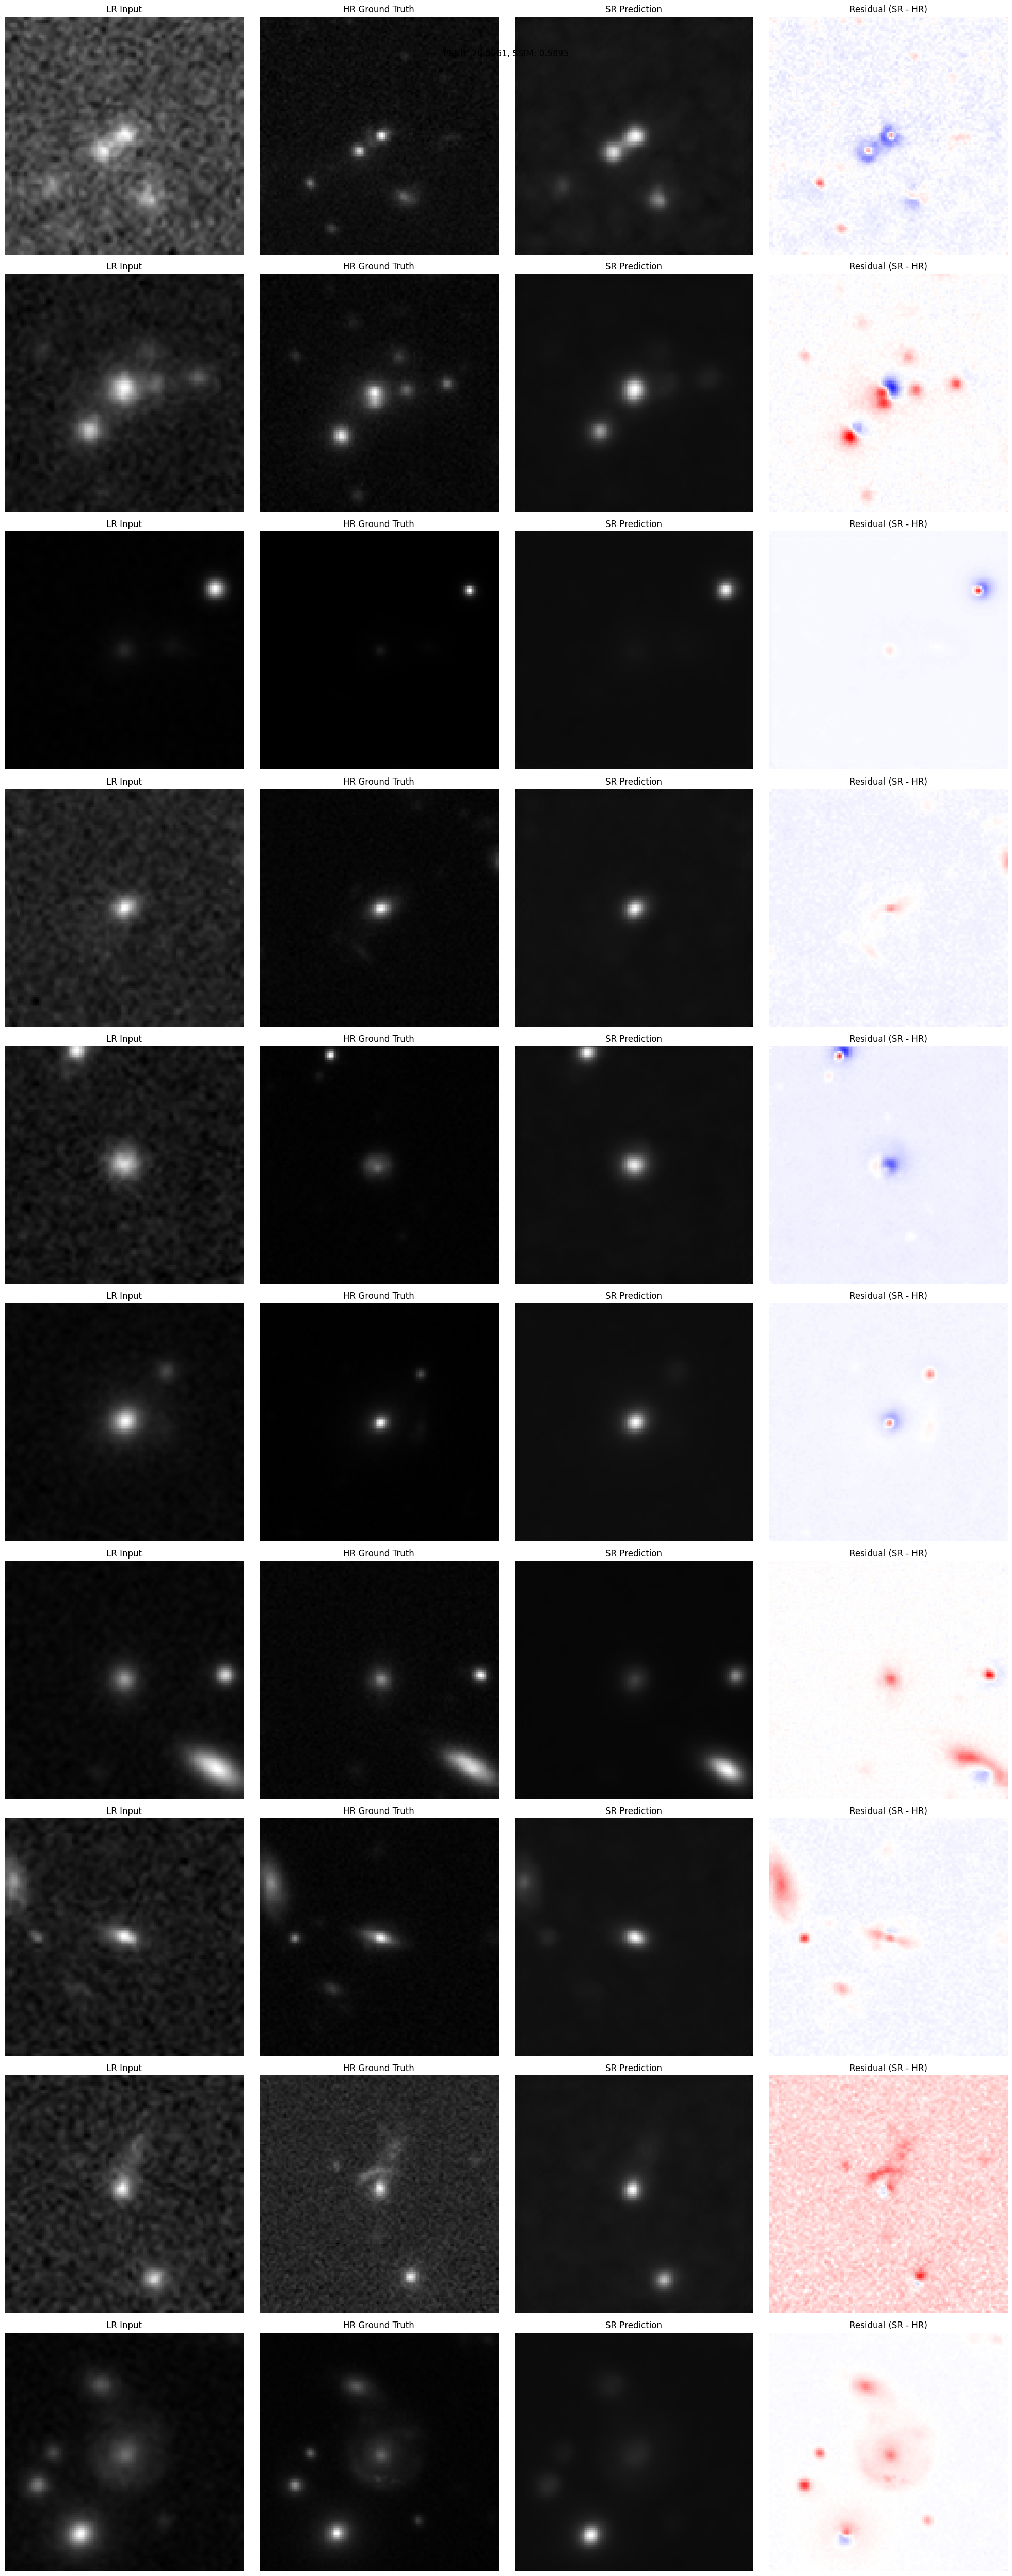

In [18]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def norma(x):
    return (x - x.min()) / (x.max() - x.min())

def plot_samples(model, test_loader, device, num_samples=10):
    model.eval()
    
    lr, hr = next(iter(test_loader))
    lr, hr = lr.to(device), hr.to(device)
    
    print(f"Input shape (lr): {lr.shape}")
    print(f"Ground truth shape (hr): {hr.shape}")
    
    with torch.no_grad():
        sr = model(lr)
    
    print(f"Model output shape (sr): {sr.shape}")

    if sr.size() != hr.size():
        sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
    
    print(f"Resized model output shape (sr): {sr.shape}")

    num_samples = min(lr.size(0), num_samples)

    residuals = hr - sr

    batch_psnr = []
    batch_ssim = []
    for i in range(num_samples):
        sr_np = norma(sr[i, 0].cpu().numpy())
        hr_np = norma(hr[i, 0].cpu().numpy())
        batch_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        batch_ssim.append(ssim(hr_np, sr_np, data_range=1.0))
    
    avg_psnr = np.mean(batch_psnr)
    avg_ssim = np.mean(batch_ssim)

    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # LR image
        axes[i, 0].imshow(lr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('LR Input')
        axes[i, 0].axis('off')
        # HR image
        axes[i, 1].imshow(hr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('HR Ground Truth')
        axes[i, 1].axis('off')
        # SR prediction
        axes[i, 2].imshow(sr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('SR Prediction')
        axes[i, 2].axis('off')
        # Residual map
        axes[i, 3].imshow(residuals[i, 0].cpu().numpy(), cmap='bwr', vmin=-0.5, vmax=0.5)
        axes[i, 3].set_title('Residual (SR - HR)')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'PSNR: {avg_psnr:.4f}, SSIM: {avg_ssim:.4f}')
    plt.show()

plot_samples(model, test_loader, device, num_samples=10) 
